# Support Vector Machine Modeling

## 1. Identify the model approach(es), describe, and justify the selection

Support vector machines (SVM) are a type of supervised learning used for classification and regression. Here, SVMs will be used to classify patients as either readmission (readmitted within 30 days of being discharged) or non_readmission. SVMs try to find a hyperplane (decision boundary) that separates classes of observations in feature space. Unlike probability models, the SVM does not use probability for classification; instead, we aim for the direct caclulation of a separating hyperplane (as in notes). Moreover, SVMs are a type of *large margin* classifiers. In these types of classifiers, we try to find the best separating hyperplane that is farthest as possible from any points. In other words, we want to minimize the norm of the parameter vector by choosing a $\theta$ such that the projection of each point x onto $\theta$ is a maximum.

Support vector machines are useful in this problem because they work well in high dimensional spaces, and we have multiple variables that we want to use to predict readmission. Even though they can use many features accurately, they are also memory efficient; SVMS only use a subset of training points in the decision function (i.e., the points "closest" to the decision boundary line, because those that lie farther from the boundary are easy to classify). Many tuning parameters are available for SVMS, including different kernels and regularization terms that can account for overfitting and bias errors. I will test multiple different kernel possibilities, and then investigate the regularization term. I expect that I will need something more nuanced than a basic Gaussian or linear kernel, and I predict that the most accurate models with come from polynomial kernels.


In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import pandas as pd 
import pymc3 as pm
import seaborn as sns
import theano
import theano.tensor as tt
import matplotlib.pylab as plt
import matplotlib.cm as cmap
sns.set_context('talk')
import seaborn as sns; sns.set_context('notebook')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.svm import SVC
from sklearn import svm
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import brier_score_loss, make_scorer
np.random.seed(1)

In [60]:
np.random.seed(1)

## 2. Code, parameterize, and run model (including visualization)


We'll start with the simplest SVM model: a linear kernel, and no regularization.

In [61]:
data_path = "/Users/sarahmaddox/Desktop/Data/" ## CHANGE TO ACCESS DATA

In [62]:
from sklearn import svm

X = pd.read_csv(data_path+"x_data.csv", index_col = "patient_id")
del X['Unnamed: 0']
y_data = pd.read_csv(data_path+"y_data.csv")
y=y_data.pop("readmitted_true")
X.head()

,bmi_mean,bmi_std,egfr_mean,egfr_std,pd_mean,pd_std,ps_mean,ps_std,U,A,B,H,I,N,W,sex_x,sex_y
patient_id,,,,,,,,,,,,,,,,,
50135262,0.232986,0.023394,0.468378,0.131599,0.343691,0.072827,0.757036,0.109282,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
50135361,0.255530,0.358638,0.330582,0.118710,0.381523,0.080783,0.718633,0.119113,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
50135369,0.174707,0.158271,0.508748,0.089971,0.420444,0.071984,0.695987,0.105619,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
50135375,0.182953,0.014560,0.242454,0.133643,0.461639,0.085380,0.805206,0.144622,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
50135425,0.219884,0.033389,0.230223,0.211236,0.370948,0.060777,0.836701,0.107461,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [63]:
svc = svm.SVC(kernel='linear')
svc.fit(X, y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [64]:
svc.score(X,y)

0.71825000000000006

This score is not too good, especially since it's predicting on data that it was given (we need to do a train and test set to actually see how good the model is, which is shown in the next section). 

In [65]:
svc.coef_

array([[-0.75480589, -1.99211743, -3.11226761,  4.19576791, -0.5753616 ,
         1.44763744, -2.81526409,  3.15844181, -0.06687702,  0.09686709,
         0.13045751,  0.07327145, -0.41306755,  0.07514881,  0.1041997 ,
         0.0143861 ,  0.0143861 ]])

In [66]:
from matplotlib.colors import ListedColormap
# Create color maps for 2-class classification problem, as with iris
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00'])

def plot_estimator(estimator, X, y, ax=None):
    
    try:
        X, y = X.values, y.values
    except AttributeError:
        pass
    
    if ax is None:
        _, ax = plt.subplots()
    
    estimator.fit(X, y)
    #X=X[["ps_std", "egfr_std"]]
    x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
    y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    ax.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
    ax.axis('tight')
    ax.axis('off')
    plt.tight_layout()

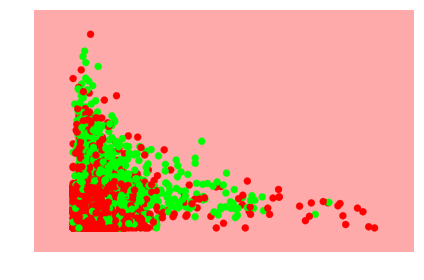

In [67]:
%matplotlib inline
plot_estimator(svc, X[["ps_std", "egfr_std"]], y)

<font color=red>AS I NOTED IN ANOTHER NOTEBOOK, A BIVARIATE PLOT IS NOT VERY INFOMRATIVE IN A MULTIVARIATE CONTEXT, UNLESS PERHAPS WE KNOW THESE ARE REALLY GOOD MAIN-EFFECT PREDICTORS.</font>

I chose to graph PS_STD and EGFR_STD because the Decision Tree Classifier chose these two metrics as having the highest feature importance. From this plot, we can see that the classifier is essentially labelling everything as red, because it can't tease apart the values and predict accurately. We definitely need to tune this model.

<font color=red>A LINEAR KERNEL IS A BIT OF A STRAW-MAN DEFAULT MODEL; ITS NOT LIKELY TO HAVE DONE VERY WELL IN THIS TYPE OF ANALYSIS.</font>

## 3. Cross-validation


Cross-validation is also important because the model above is using all the data and then predicting on all the data, which is not what we're trying to train the model to do. If the model can't even predict what it's been given, it's probably not very good anyway, but we'll check how it does with a train set and test set.

In [68]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(
        X.values, y.values, test_size=0.4, random_state=0)

svc = svm.SVC(kernel='linear')
svc.fit(X_train, y_train)
svc.score(X_test, y_test)

0.7109375

In [69]:
#5 fold cross-validation, 5 way partition 
scores = model_selection.cross_val_score(svc, X.values, y.values, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.72 (+/- 0.01)


In [70]:
pred_train = svc.predict(X_train)
pred_test = svc.predict(X_test)

In [71]:
pd.crosstab(y_train, pred_train, 
            rownames=["Actual"], colnames=["Predicted"])

Predicted,0.0,1.0
Actual,,
0.0,3256,105
1.0,1239,200


This model does a fairly bad job at predicting when the actual is 1; it is more often predicted as 0 even if the actual value is one (1224 versus 215). The model is probably biased towards predicting that the patient is not readmitted within 30 days. We will need to tune the model, and probably change the kernel (linear can't even capture the readmission rates when they are given as input, so we need a more nuanced kernel that can).

## 4. Improvements to model/tuning of parameters; model selection methods, justification of improvements/tests


### Regularization

C corresponds to the inverse of the regularization parameter. The choice of C will either help reduce bias, reduce variance, or something in the middle:
large C = low bias, high variance
small C = high bias, low variance
In an SVM, a lot of regularization means that the model will have a "soft margin" that allows some points to cross the optimal decision boundary and get misclassified. 


In [73]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
        X.values, y.values, test_size=0.4, random_state=0)
s=np.zeros(3)
i=0
for C in 0.1, 0.4, 2:
    svc = svm.SVC(kernel='linear', C = C)
    svc.fit(X_train, y_train)
    s[i]=svc.score(X_test, y_test)
    i=i+1

In [74]:
s

array([ 0.6928125,  0.6971875,  0.71375  ])

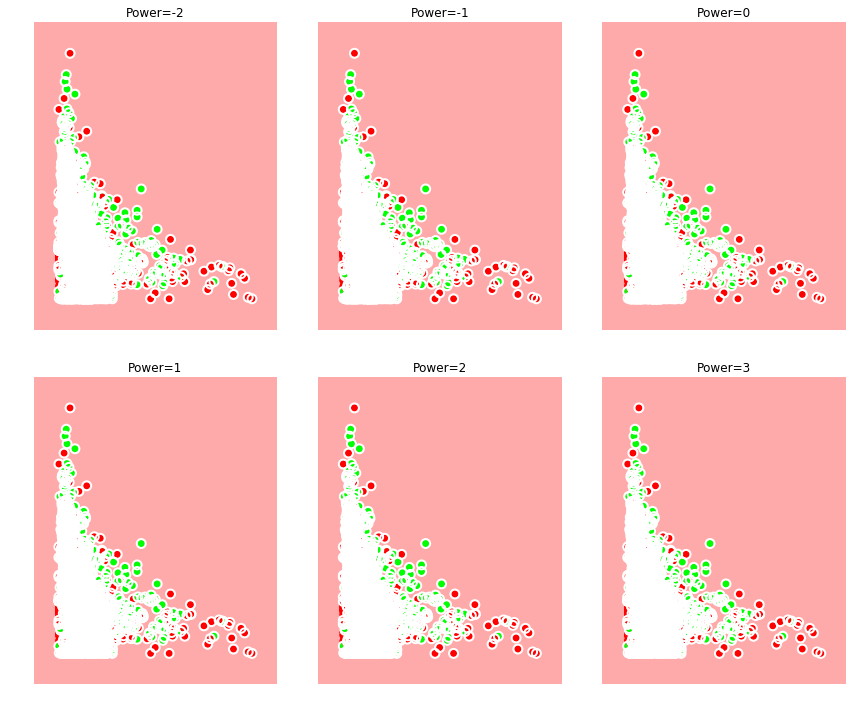

In [75]:
def plot_regularized(power, ax):
    svc = svm.SVC(kernel='linear', C=10**power)
    plot_estimator(svc, X[["ps_std", "egfr_std"]], y, ax=ax)
    ax.scatter(svc.support_vectors_[:, 0], svc.support_vectors_[:, 1], s=80, 
            facecolors='none', edgecolors='w', linewidths=2, zorder=10)
    ax.set_title('Power={}'.format(power))
    
fig, axes = plt.subplots(2, 3, figsize=(12,10))
for power, ax in zip(range(-2, 4), axes.ravel()):
    plot_regularized(power, ax)

Regularization is not helping this model at all. Let's try different kernels:

### Kernel Type

[ 0.69725  0.69725  0.69725  0.69725  0.69725  0.69725]


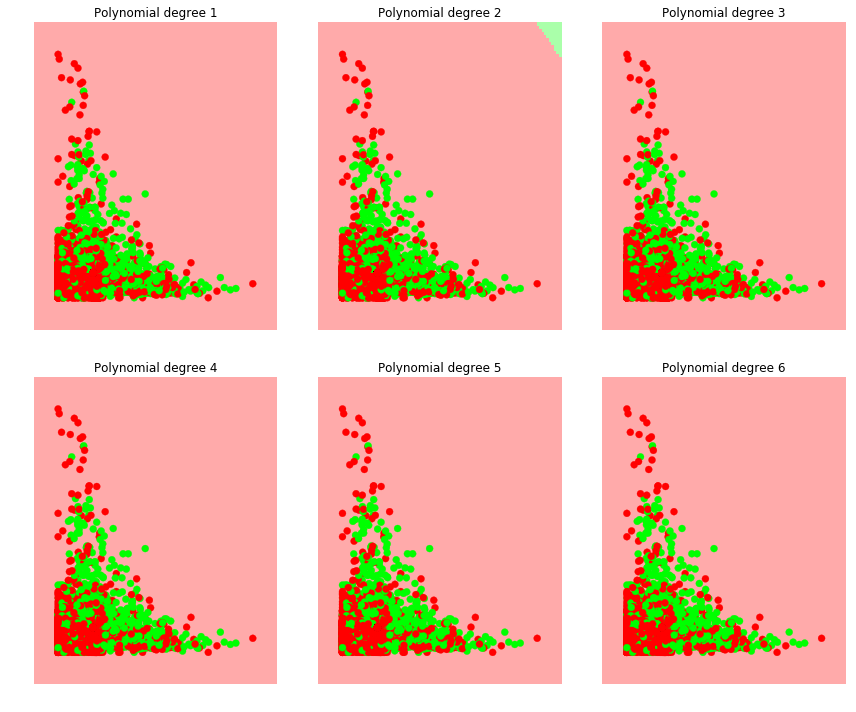

In [79]:
scores = np.zeros(6)
def plot_poly_svc(degree=3, ax=None):
    svc_poly = svm.SVC(kernel='poly', degree=degree)
    plot_estimator(svc_poly, X[["egfr_std", 'ps_std']], y, ax=ax)
    ax.scatter(svc_poly.support_vectors_[:, 0], svc_poly.support_vectors_[:, 1], 
               s=80, facecolors='none', linewidths=2, zorder=10)
    ax.set_title('Polynomial degree {}'.format(degree))
    scores[degree-1]=svc_poly.score(X[["egfr_std", 'ps_std']],y)
fig, axes = plt.subplots(2, 3, figsize=(12,10))
for deg, ax in zip(range(1, 7), axes.ravel()):
    plot_poly_svc(deg, ax)
print(scores)

Different polynomial kernels don't make a difference. We'll try the Gaussian:

[ 0.70225   0.7195    0.73475   0.746875  0.77325   0.842   ]


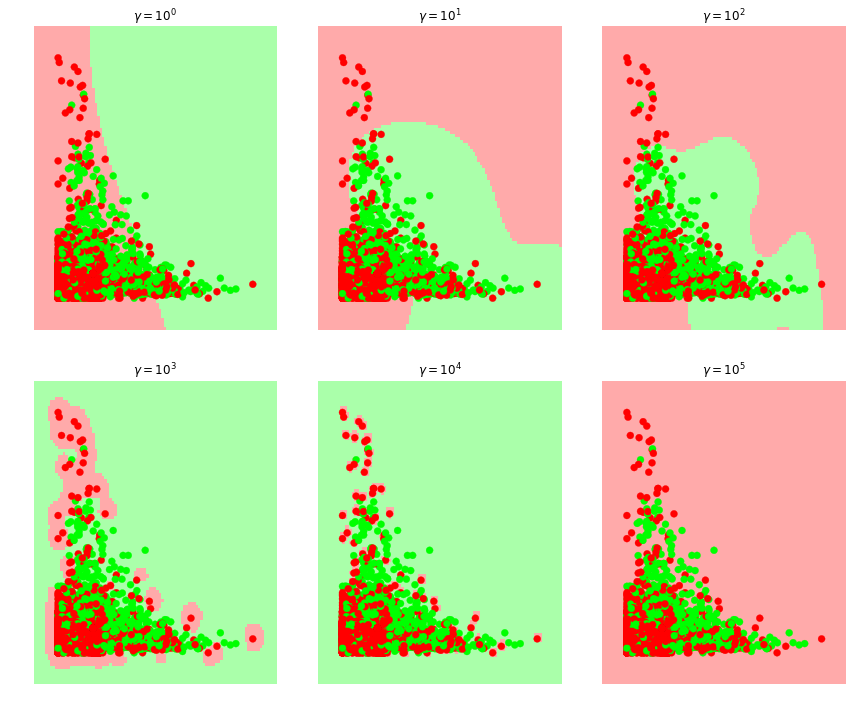

In [85]:
scores = np.zeros(6)

def plot_rbf_svc(power=1, ax=None):

    svc_rbf = svm.SVC(kernel='rbf', gamma=10**power)
    plot_estimator(svc_rbf, X[["egfr_std", 'ps_std']], y, ax=ax)
    ax.scatter(svc_rbf.support_vectors_[:, 0], svc_rbf.support_vectors_[:, 1], 
               s=80, facecolors='none', linewidths=2, zorder=10)
    ax.set_title('$\gamma=10^{%i}$' % power)
    scores[power]=svc_rbf.score(X[["egfr_std", 'ps_std']],y)

fig, axes = plt.subplots(2, 3, figsize=(12,10))
for pow, ax in zip(range(0, 6), axes.ravel()):
    plot_rbf_svc(pow, ax)
print(scores)

When the power = 3, it definitely looks like overfitting; the things labeled red are very specific to the data that was put in, and the decision boundary is way too compartmentalized. However, I think a gamna kernel with gamma = $10^2$ looks pretty good, and has a slightly better accuracy than the other models. We'll use this model going forward. 

## 5. Goodness of fit assessments, performance characteristics (including visualization)


### Types of fit assessments
For an SVM, the default estimator score method is a mean accuracy. Alternatively, with cross-validation is it possible to specify different scoring metrics, which includes:

**accuracy**
:	`sklearn.metrics.accuracy_score`

**average_precision**
:	`sklearn.metrics.average_precision_score`

**f1**
:	`sklearn.metrics.f1_score`

**precision**
:	`sklearn.metrics.precision_score`

**recall**
:	`sklearn.metrics.recall_score`

**roc_auc**
:	`sklearn.metrics.roc_auc_score`

Each of these are implemented below. They are based on the cross-validated model above (based on X_train and y_train).

In [94]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
        X.values, y.values, test_size=0.4, random_state=0)

svc = svm.SVC(kernel='rbf', gamma = 10**2)
svc.fit(X_train, y_train)
pred_train = svc.predict(X_train)
pred_test = svc.predict(X_test)
svc.score(X_test, y_test)

0.73124999999999996

### Precision Score

In [93]:
from sklearn.metrics import precision_score
y_scores = svc.predict(X)
precision_score(y, y_scores)

0.76533115290269826

A precision score gives the number of true positives over total (true and false) positive predictions. This is a pretty good precision score, which means that we don't have too many false positives (people who didn't actually return within 30 days but were predicted to). 

### Recall Score

In [92]:
from sklearn.metrics import recall_score
y_scores = svc.predict(X)
recall_score(y, y_scores)

0.38645747316267548

Our recall score is very low. This is the number of true positives over the number of true positives and false negatives (total number of actually positive results). This suggests that we have many false negatives, or people who actually did come back to the hospital within 30 days but were predicted not to. We can see this in the table below: 794 false negatives compared to 645 true positives. 

In [95]:
pd.crosstab(y_train, pred_train, 
            rownames=["Actual"], colnames=["Predicted"])

Predicted,0.0,1.0
Actual,,
0.0,3242,119
1.0,794,645


## 6. Comparison of models; identification of best model


The visual comparison is shown above, but cross tables are shown below for different types of models. The best model was used for the scoring above, which is the RBF kernel with gamma = 100 and no regularization.

### Best Model: RBF Kernel, gamma = 100, C = 0

In [96]:
svc_rbf_100 = svm.SVC(kernel='rbf', gamma = 10**2)
svc_rbf_100.fit(X_train, y_train)
pred_train_rbf_100 = svc_rbf_100.predict(X_train)
pred_test_rbf_100 = svc_rbf_100.predict(X_test)
svc_rbf_100.score(X_test, y_test)

0.73124999999999996

In [97]:
pd.crosstab(y_train, pred_train_rbf_100, 
            rownames=["Actual"], colnames=["Predicted"])

Predicted,0.0,1.0
Actual,,
0.0,3242,119
1.0,794,645


### RBF Kernel, gamma = 1

In [98]:
svc_rbf_1 = svm.SVC(kernel='rbf', gamma = 1)
svc_rbf_1.fit(X_train, y_train)
pred_train_rbf_1 = svc_rbf_1.predict(X_train)
pred_test_rbf_1 = svc_rbf_1.predict(X_test)
svc_rbf_1.score(X_test, y_test)

0.70750000000000002

In [99]:
pd.crosstab(y_train, pred_train_rbf_1, 
            rownames=["Actual"], colnames=["Predicted"])

Predicted,0.0,1.0
Actual,,
0.0,3279,82
1.0,1244,195


### Polynomial kernel, Degree = 3

In [101]:
svc_poly_3 = svm.SVC(kernel='poly', degree = 3)
svc_poly_3.fit(X_train, y_train)
pred_train_poly_3 = svc_poly_3.predict(X_train)
pred_test_poly_3 = svc_poly_3.predict(X_test)
svc_poly_3.score(X_test, y_test)

0.69281250000000005

In [102]:
pd.crosstab(y_train, pred_train_poly_3, 
            rownames=["Actual"], colnames=["Predicted"])

Predicted,0.0
Actual,
0.0,3361
1.0,1439


### RBF Kernel, Gamma = 100, C = .1

In [105]:
svc_rbf_c = svm.SVC(kernel='rbf', gamma = 100, C = .1)
svc_rbf_c.fit(X_train, y_train)
pred_train_rbf_c = svc_rbf_c.predict(X_train)
pred_test_rbf_c = svc_rbf_c.predict(X_test)
svc_rbf_c.score(X_test, y_test)

0.69437499999999996

In [106]:
pd.crosstab(y_train, pred_train_rbf_c, 
            rownames=["Actual"], colnames=["Predicted"])

Predicted,0.0,1.0
Actual,,
0.0,3358,3
1.0,1420,19


## 7. Results and Implications of model and conclusions


The data is clearly not linearly separable, and requires a more complex model for prediction. With the messiness of the data and the data imputation that we had to do, I think this suggests that the accuracy of the model without overfitting will not be able to reach 100%, and therefore I think 73% is pretty good. There was a big problem with false negatives: saying a patient would not return even if they did. This makes sense, because most of the patients don't return within 30 days by a wide margin. If the model is going to "make a guess," it might as well guess negative because it has a 70% chance of getting it right. I think it is important to look at not just the accuracy but other scoring methods as well; since the model that says "always choose negative" is accurate 70% of the time, it's hard to tell just from accuracy which models are better than others.